# Comparing proposed objectivity detection methods on movies dataset

In [21]:
import numpy as np
from sklearn.metrics import auc, roc_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [22]:
def read_file(path):
    """ Read file returns a shuttled list.
    """
    with open(path, encoding = "ISO-8859-1") as f:
        content = np.array(f.readlines())
    return content

In [23]:
PATH = 'data/rotten_imdb/'
sub_content = read_file(PATH + "quote.tok.gt9.5000")
obj_content = read_file(PATH + "plot.tok.gt9.5000")
sub_content = np.array([line.strip().lower() for line in sub_content])
obj_content = np.array([line.strip().lower() for line in obj_content])
sub_y = np.zeros(len(sub_content))
obj_y = np.ones(len(obj_content))
X = np.append(sub_content, obj_content)
y = np.append(sub_y, obj_y)

## TextBlob

In [24]:
from textblob import TextBlob

In [25]:
textblob_pred = np.empty(len(y))
for i, sentence in enumerate(X):
    blob = TextBlob(sentence)
    textblob_pred[i] = blob.sentiment.subjectivity

In [26]:
fpr_blob, tpr_blob, thresholds = roc_curve(y, 1-textblob_pred)

Text(0.4, 0.4, 'auc=0.607211')

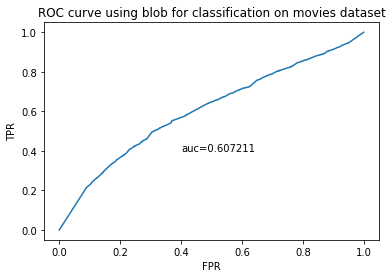

In [27]:
plt.plot(fpr_blob, tpr_blob)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve using blob for classification on movies dataset')
plt.text(0.4, 0.4, f'auc={auc(fpr_blob, tpr_blob)}')
# plt.savefig('plots/blob_roc.png')

In [28]:
print(auc(fpr_blob, tpr_blob))

0.607211


## Vader

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [30]:
sid_obj = SentimentIntensityAnalyzer()
vader_pred = np.empty(len(y))
for i, sentence in enumerate(X):
    sentiment_dict = sid_obj.polarity_scores(sentence)
    vader_pred[i] = sentiment_dict["neu"]

In [31]:
fpr_vader, tpr_vader, thresholds = roc_curve(y, vader_pred)

Text(0.4, 0.4, 'auc=0.58368212')

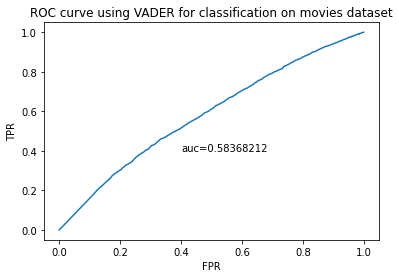

In [32]:
plt.plot(fpr_vader, tpr_vader)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve using VADER for classification on movies dataset')
plt.text(0.4, 0.4, f'auc={auc(fpr_vader, tpr_vader)}')
# plt.savefig('plots/blob_roc.png')

## Untrained Transformer

In [33]:
from transformers import pipeline

In [34]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [35]:
#sample = np.random.choice(len(y), 1000)

In [36]:
o = sentiment_pipeline(["By HOLLY RAMER, Associated PressCONCORD, N.H. -- A sick American engineer who was successfully evacuated from the South Pole to New Zealand is awaiting the results of medical tests after having what doctors believed was a stroke in August.Renee-Nicole Douceur told The Associated Press in an email Tuesday that she had MRI and echocardiogram exams."])

In [37]:
sentiment_pipeline(["By HOLLY RAMER, Associated PressCONCORD, N.H. -- A sick American engineer who was successfully evacuated from the South Pole to New Zealand is awaiting the results of medical tests after having what doctors believed was a stroke in August."])

[{'label': 'NEGATIVE', 'score': 0.9881021976470947}]

In [38]:
sentiment_pipeline(["Renee-Nicole Douceur told The Associated Press in an email Tuesday that she had MRI and echocardiogram exams."])

[{'label': 'NEGATIVE', 'score': 0.9923093318939209}]

In [39]:
sentiment_pipeline(["Help me!"])

[{'label': 'NEGATIVE', 'score': 0.5748379826545715}]

In [40]:
sentiment_pipeline(["She was yelling, 'Help me"])

[{'label': 'NEGATIVE', 'score': 0.9984684586524963}]

In [41]:
output = sentiment_pipeline(X.tolist())

In [42]:
transformer_pred = [1-i['score'] for i in output]

In [43]:
fpr_transformer, tpr_transformer, thresholds = roc_curve(y, transformer_pred)

Text(0.4, 0.4, 'auc=0.58368212')

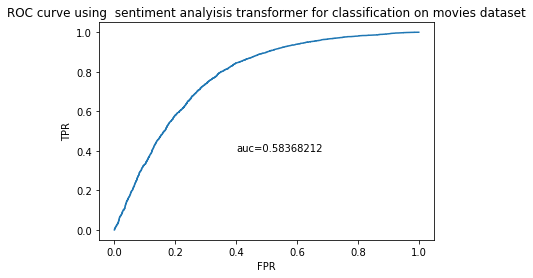

In [44]:
plt.plot(fpr_transformer, tpr_transformer)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve using  sentiment analyisis transformer for classification on movies dataset')
plt.text(0.4, 0.4, f'auc={auc(fpr_vader, tpr_vader)}')

#plt.savefig('plots/transformer_roc.png')

In [45]:
accs = [accuracy_score(y, np.array(transformer_pred) > thresh) for thresh in thresholds]
np.max(accs)

0.7254

## compound classifier with various features

In [46]:
X_features = np.array([textblob_pred, vader_pred, transformer_pred]).T

In [47]:
X_train, X_test, y_train, y_test, train_ix, test_ix = train_test_split(X_features, y, np.arange(len(y), dtype=int), test_size=0.2, random_state=86)

In [48]:
model = LinearRegression().fit(X_train, y_train)
lm_pred = model.predict(X_test)

In [49]:
fpr_lm, tpr_lm, thresholds = roc_curve(y_test, lm_pred)

Text(0.4, 0.4, 'auc=0.6600438542087635')

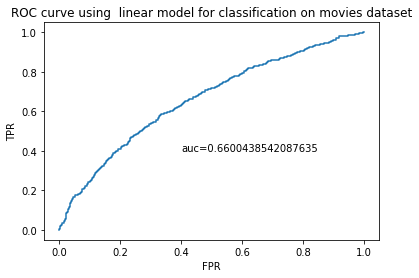

In [50]:
plt.plot(fpr_lm, tpr_lm)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve using  linear model for classification on movies dataset')
plt.text(0.4, 0.4, f'auc={auc(fpr_lm, tpr_lm)}')

In [51]:
print(auc(fpr_lm, tpr_lm))

0.6600438542087635


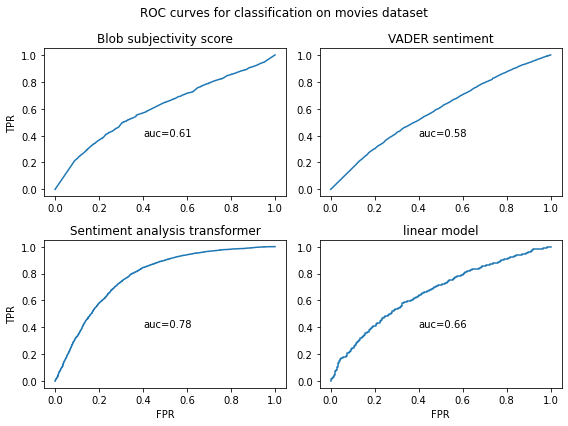

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(8,6))
ax[0,0].plot(fpr_blob, tpr_blob)
# ax[0,0].set_xlabel('FPR')
ax[0,0].set_ylabel('TPR')
ax[0,0].set_title('Blob subjectivity score')
ax[0,0].text(0.4, 0.4, f'auc={auc(fpr_blob, tpr_blob):.2f}')

ax[0,1].plot(fpr_vader, tpr_vader)
# ax[0,1].set_xlabel('FPR')
# ax[0,1].set_ylabel('TPR')
ax[0,1].set_title('VADER sentiment')
ax[0,1].text(0.4, 0.4, f'auc={auc(fpr_vader, tpr_vader):.2f}')

ax[1,0].plot(fpr_transformer, tpr_transformer)
ax[1,0].set_xlabel('FPR')
ax[1,0].set_ylabel('TPR')
ax[1,0].set_title('Sentiment analysis transformer')
ax[1,0].text(0.4, 0.4, f'auc={auc(fpr_transformer, tpr_transformer):.2f}')

ax[1,1].plot(fpr_lm, tpr_lm)
ax[1,1].set_xlabel('FPR')
# ax[1,1].set_ylabel('TPR')
ax[1,1].set_title('linear model')
ax[1,1].text(0.4, 0.4, f'auc={auc(fpr_lm, tpr_lm):.2f}')

fig.suptitle('ROC curves for classification on movies dataset')
fig.tight_layout()
fig.savefig('plots/subjectivity_eda.png')

In [ ]:
accuracy_score(y_test, lm_pred > 0.5)

0.6175

In [ ]:
model_rf = RandomForestClassifier().fit(X_train, y_train)
rf_pred = model_rf.predict(X_test)

In [ ]:
accuracy_score(y_test, rf_pred)

0.685

In [ ]:
transformer_pred_np = np.array(transformer_pred)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, transformer_pred_np[train_ix])
accs = [accuracy_score(y_train, np.array(transformer_pred_np[train_ix]) > thresh) for thresh in thresholds]
db = thresholds[np.argmax(accs)]

In [ ]:
accuracy_score(y_test, transformer_pred_np[test_ix] > db)

0.7235